In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pandas-ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=2e1b743204d12e96a632f20161d45fe9e1cc70db166f8da46d8d7c4b51b2a4c7
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas-ta


In [ ]:
import os
import time
import numpy as np
import pandas as pd
import polars as pl
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
import pandas_ta as ta

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Thesis/fpt_stock.csv")

In [ ]:
df = df.iloc[:,1:-1]
df

,open,high,low,close,volume
0,6950,6950,6900,6900,94310
1,6900,6950,6840,6900,145260
2,6900,6900,6780,6780,90050
3,6840,6840,6780,6840,71320
4,6840,6840,6780,6840,112360
...,...,...,...,...,...
2930,95500,95700,94600,95000,1564500
2931,95400,96800,95300,96800,4084900
2932,97400,97400,95200,95200,2148100
2933,95800,96400,95200,96200,1712300


In [ ]:
df.describe()

,open,high,low,close,volume
count,2935.000000,2935.000000,2935.000000,2935.000000,2.935000e+03
mean,28498.660988,28812.749574,28204.461329,28503.288245,1.192762e+06
std,24585.754320,24870.264111,24302.386807,24591.287223,1.049063e+06
min,4930.000000,5010.000000,4920.000000,4990.000000,4.970000e+03
25%,11065.000000,11210.000000,10995.000000,11050.000000,4.342650e+05
50%,18300.000000,18400.000000,18140.000000,18280.000000,9.070000e+05
75%,37020.000000,37560.000000,36005.000000,36990.000000,1.653370e+06
max,99000.000000,100800.000000,98500.000000,99000.000000,8.399400e+06


In [ ]:
df.isna().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

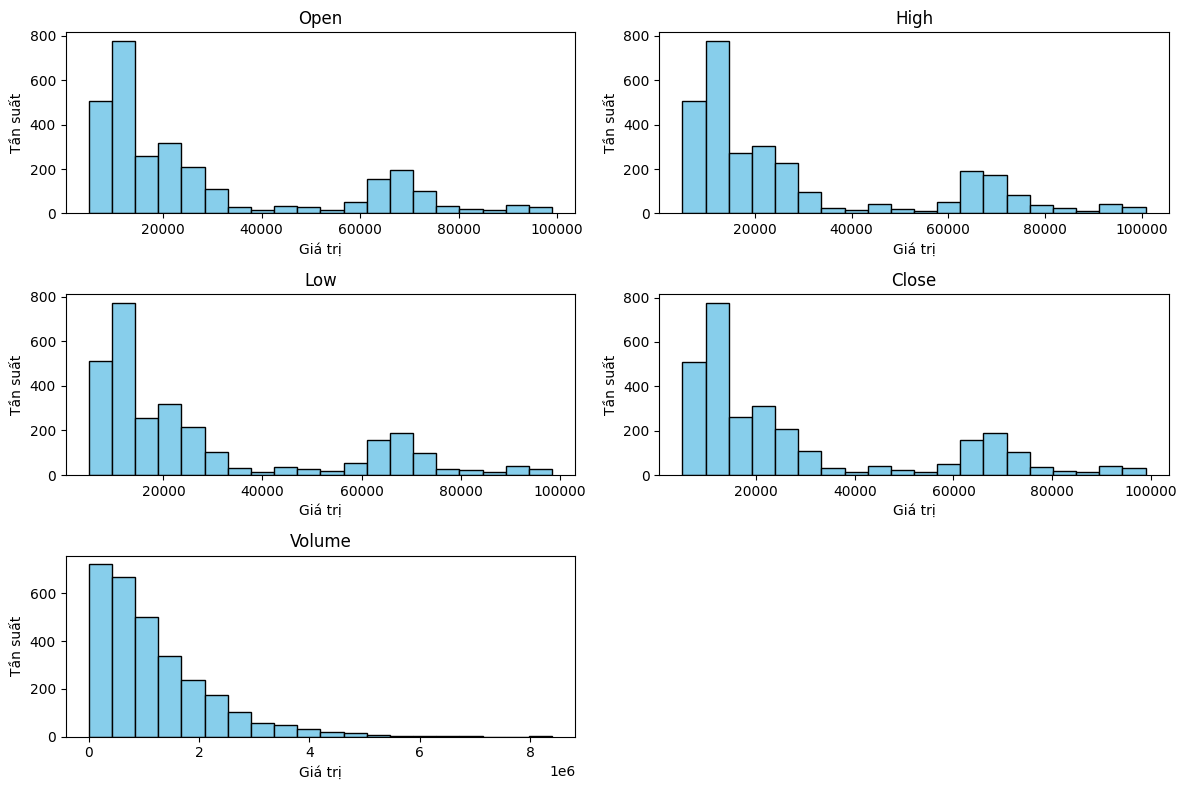

In [ ]:
plt.figure(figsize=(12, 8))

for i, col in enumerate(df.columns):
    plt.subplot(3, 2, i+1)
    plt.hist(df[col], bins=20, color='skyblue', edgecolor='black')
    plt.title(col.capitalize())
    plt.xlabel('Giá trị')
    plt.ylabel('Tần suất')

plt.tight_layout()
plt.show()

In [ ]:
path = "/content/drive/MyDrive/Thesis/fpt_stock.csv"

df = pd.read_csv(path).iloc[:,:-1]
df_features = df.iloc[:,1:]
# Features engineering
df_features['ROC'] = ta.roc(df_features.close, length=15)
df_features['%R'] = ta.willr(close = df_features.close, high = df_features.high, low = df_features.low, length=14)
df_features['CCI'] = ta.cci(close = df_features.close, high = df_features.high, low = df_features.low, length=14, c=0.015)
df_features['RSI'] = ta.rsi(close = df_features.close, high = df_features.high, low = df_features.low, length=14, scalar=100, drift=1)
df_features['OBV'] = ta.obv(close = df_features.close, volume = df_features.volume)

# Normalization
df_array = df_features.values
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_array = scaler.fit_transform(df_array)
normalized_df = pd.DataFrame(normalized_array, columns=df_features.columns)
normalized_df.insert(0, "time", df["time"])
df = normalized_df.dropna(inplace=False)

In [ ]:
path = "/content/drive/MyDrive/Thesis/fpt_stock.csv"

df = pd.read_csv(path).iloc[:,:-1]
df_features = df.iloc[:,1:]

df_features['ROC'] = ta.roc(df_features.close, length=15)
df_features['%R'] = ta.willr(close = df_features.close, high = df_features.high, low = df_features.low, length=14)
df_features['CCI'] = ta.cci(close = df_features.close, high = df_features.high, low = df_features.low, length=14, c=0.015)
df_features['RSI'] = ta.rsi(close = df_features.close, high = df_features.high, low = df_features.low, length=14, scalar=100, drift=1)
df_features['OBV'] = ta.obv(close = df_features.close, volume = df_features.volume)

df_features.insert(0, "time", df["time"])

df = df_features.dropna(inplace=False)

In [ ]:
df.head()

,time,open,high,low,close,volume,ROC,%R,CCI,RSI,OBV
15,2012-04-11,7140,7370,7080,7370,401940,6.811594,0.000000,193.732996,87.736776,1129780.0
16,2012-04-12,7430,7490,7370,7430,181420,7.681159,-7.228916,198.343505,88.917335,1311200.0
17,2012-04-13,7430,7430,7200,7200,129430,6.194690,-34.939759,110.387158,63.629858,1181770.0
18,2012-04-16,7310,7430,7260,7310,128380,6.871345,-21.686747,110.786914,68.276598,1310150.0
19,2012-04-17,7430,7430,7260,7370,123760,7.748538,-14.457831,100.474342,70.491212,1433910.0


In [ ]:
df.describe()

,open,high,low,close,volume,ROC,%R,CCI,RSI,OBV
count,2920.000000,2920.000000,2920.000000,2920.000000,2.920000e+03,2920.000000,2920.000000,2920.000000,2920.000000,2.920000e+03
mean,28609.595890,28925.020548,28314.220548,28614.291438,1.198066e+06,1.538956,-46.418430,21.435866,54.400584,1.200732e+08
std,24599.930575,24884.558775,24316.309444,24605.429197,1.049102e+06,6.184238,28.968128,107.458230,12.223988,1.094916e+08
min,4930.000000,5010.000000,4920.000000,4990.000000,4.970000e+03,-25.764192,-100.000000,-347.855392,14.908839,-3.592070e+06
25%,11130.000000,11257.500000,11040.000000,11120.000000,4.442150e+05,-2.100205,-70.819921,-60.577892,46.042071,2.903616e+07
50%,18320.000000,18480.000000,18175.000000,18320.000000,9.106050e+05,1.428179,-44.000000,30.187128,54.262205,9.503818e+07
75%,37400.000000,38332.500000,36862.500000,37410.000000,1.656900e+06,4.742649,-20.833333,100.522006,62.442566,2.153193e+08
max,99000.000000,100800.000000,98500.000000,99000.000000,8.399400e+06,30.002888,0.000000,338.382979,91.445727,3.502717e+08


In [ ]:
nan_values= df.isna().sum()

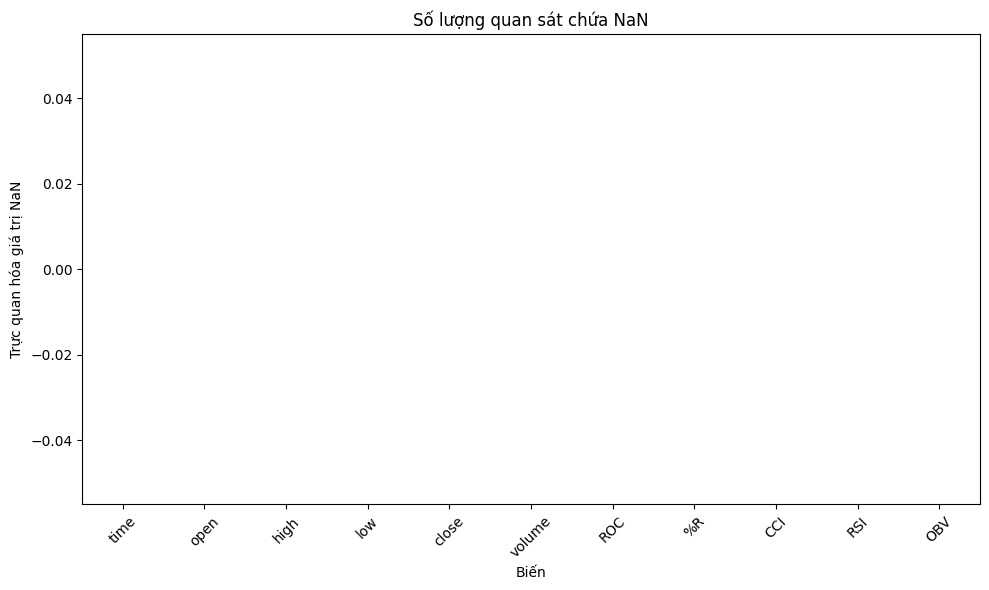

In [ ]:
plt.figure(figsize=(10, 6))
nan_values.plot(kind='bar', color='skyblue')
plt.title('Số lượng quan sát chứa NaN')
plt.xlabel('Biến')
plt.ylabel('Trực quan hóa giá trị NaN')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

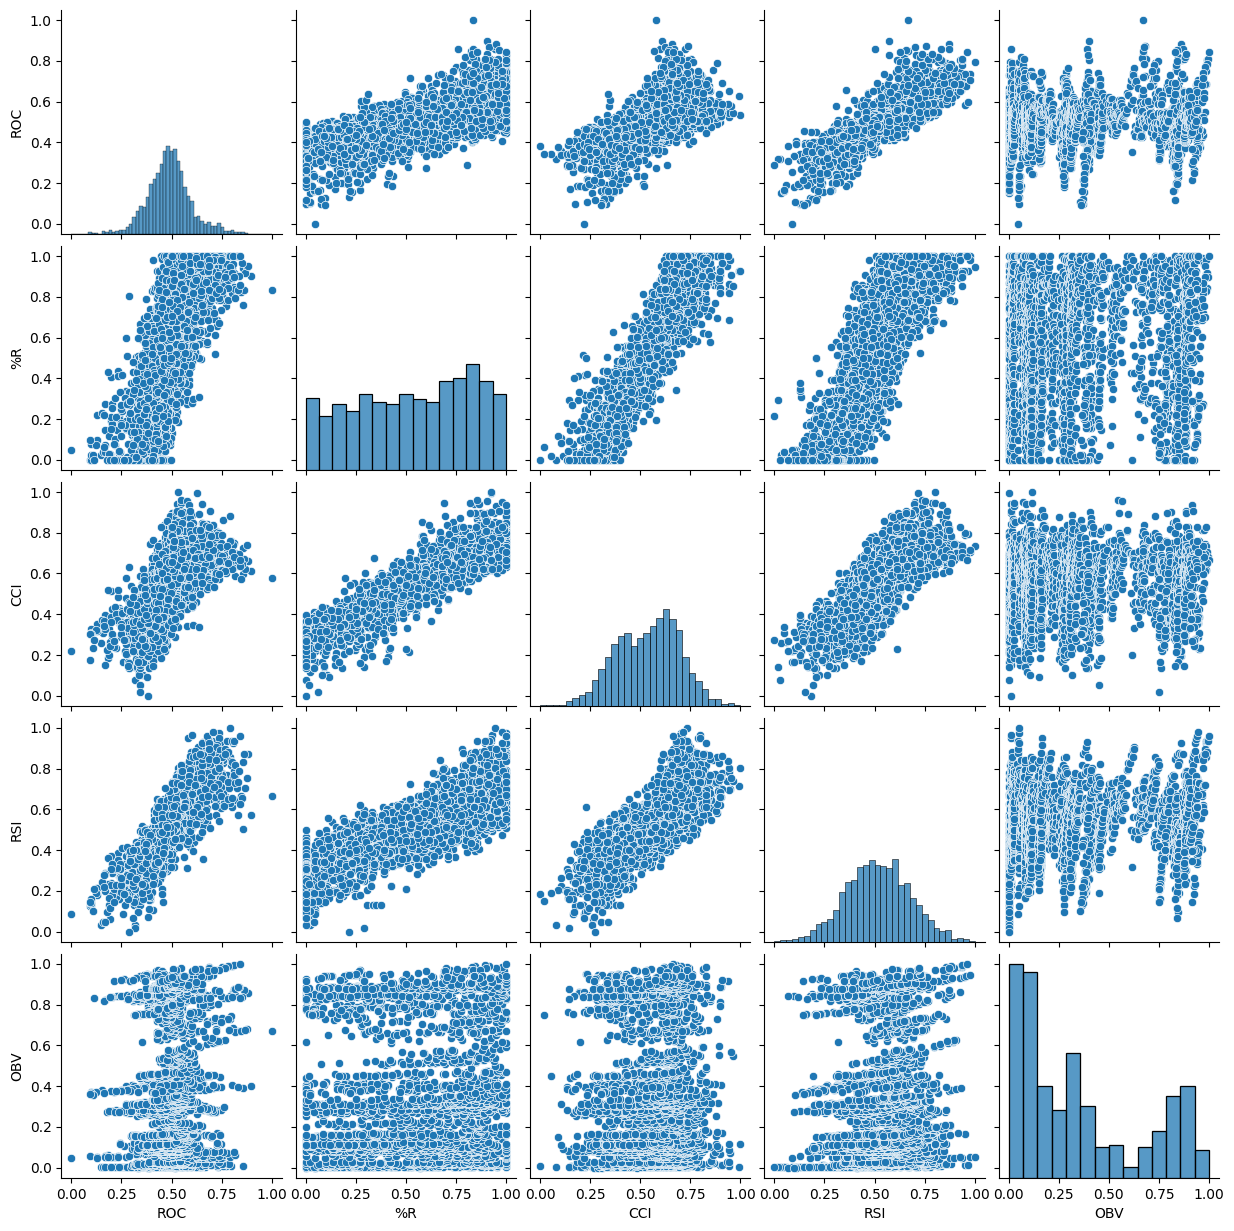

In [ ]:
sns.pairplot(df[['ROC', '%R', 'CCI', 'RSI', 'OBV']])
plt.show()


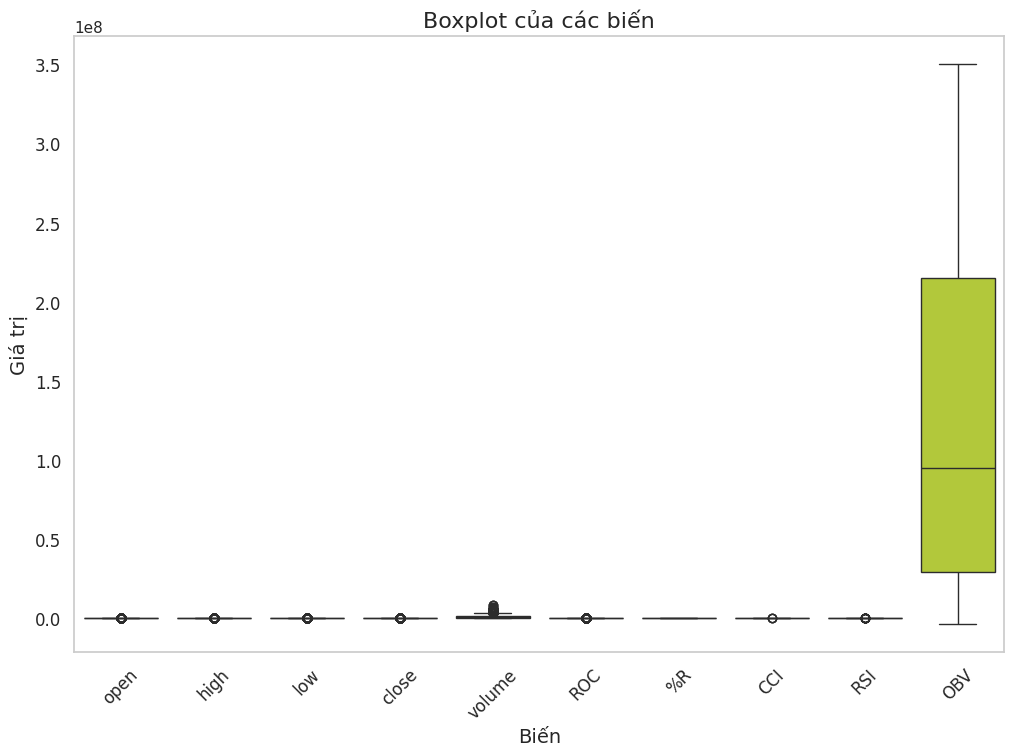

In [ ]:
ns.set(style="whitegrid")

plt.figure(figsize=(12, 8))
sns.boxplot(data=df.drop(columns=['time']), palette='viridis')
plt.title('Boxplot của các biến', fontsize=16)
plt.xlabel('Biến', fontsize=14)
plt.ylabel('Giá trị', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(False)
plt.show()